In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

1.15.0


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

## Import data

In [0]:
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
random.seed(101)

DATA_RAW_FOLDER = "../data/raw"
DATA_RAW_IMAGE_FOLDER = "../data/raw/original images" 
DATA_TRAIN_FOLDER = "../data/train"
DATA_TEST_FOLDER = "../data/test"

SAMPLE_TRAIN_FOLDER = '../data/samples/train'
SAMPLE_TEST_FOLDER = '../data/samples/test'

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
df1 = pd.read_csv(DATA_RAW_FOLDER + '/image sets/train.txt', sep='\s', names =['image_name','gender'])
df2 = pd.read_csv(DATA_RAW_FOLDER + '/image sets/val.txt', sep='\s', names =['image_name','gender'])

df = pd.concat([df1,df2], ignore_index = True)

print(df1.shape)
print(df2.shape)
print(df.shape)

(6637, 2)
(6685, 2)
(13322, 2)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [0]:
print(df.head())

#check shape of dataframe
print(df.shape)

#check the number of male and female
print('The number of male with label of 1:' ,df['gender'].value_counts()[1])
print('The number of female with label of 0:' ,df['gender'].value_counts()[0])

     image_name  gender
0  00000A02.jpg       0
1  00002A02.jpg       0
2  00004A02.jpg       0
3  00006A02.jpg       0
4  00008A02.jpg       0
(13322, 2)
The number of male with label of 1: 5941
The number of female with label of 0: 7381


In [0]:
## Create a train and test folders
img_folder = pathlib.Path(DATA_RAW_IMAGE_FOLDER)

all_image_paths = [item for item in img_folder.glob('*/') if item.is_file()]
random.shuffle(all_image_paths)

num_img = len(all_image_paths)
test_ratio = 0.2


for ind, path in enumerate(all_image_paths):
    label = df[df['image_name'] == path.name]['gender'].values[0]
    dst = DATA_TRAIN_FOLDER
    
    if ind < int(num_img * test_ratio):
        dst = DATA_TEST_FOLDER
    
    if label == 0:
        shutil.copy(str(path), os.path.join(dst,'female'))
    elif label == 1:
        shutil.copy(str(path), os.path.join(dst,'male'))

In [0]:
# Take samples from orginal data

train_data = pathlib.Path(DATA_TRAIN_FOLDER)
labels = ['male','female']
# for label in labels:
#     os.makedirs(SAMPLE_TRAIN_FOLDER + '/' + label)
#     os.makedirs(SAMPLE_TEST_FOLDER + '/' + label)

train_male = [str(item) for item in train_data.glob('*/*') if item.parent.name == 'male' and item.is_file()] 
train_female = [str(path) for path in train_data.glob('*/*') if path.parent.name == 'female' and path.is_file()]

n_sample = 2000
test_size = 0.2
sample_male = random.sample(train_male, n_sample//2)
sample_female = random.sample(train_female, n_sample//2)

assert len(sample_male) + len(sample_female) == n_sample

# Move sample images to data/train and data/test
for i in range(n_sample//2):
    if i < (n_sample * test_size // 2):
        shutil.copy(sample_male[i], os.path.join(SAMPLE_TEST_FOLDER, 'male'))
        shutil.copy(sample_female[i], os.path.join(SAMPLE_TEST_FOLDER, 'female'))
    else:
        shutil.copy(sample_male[i], os.path.join(SAMPLE_TRAIN_FOLDER, 'male'))
        shutil.copy(sample_female[i], os.path.join(SAMPLE_TRAIN_FOLDER, 'female'))

In [0]:
!ls -1q ../data/train/*/* | wc -l
!ls -1q ../data/test/*/* | wc -l

10658
2664


In [0]:
!ls -1q ../data/samples/train/*/* | wc -l
!ls -1q ../data/samples/test/*/* | wc -l

1600
400


### Prepare samples

In [0]:
def clean_ipynb_folder_if_exists(folder):
    folder = pathlib.Path(folder)
    ipynb_paths = [str(item) for item in folder.glob('**/*') if item.is_dir() and item.name.startswith('.ipynb')]
    if len(ipynb_paths) > 0:
        for eachdir in ipynb_paths:
            shutil.rmtree(eachdir)
            print("Removed", eachdir)
    else:
        print('No .ipynb_checkpoints to remove')
        
clean_ipynb_folder_if_exists(DATA_TRAIN_FOLDER)
clean_ipynb_folder_if_exists(DATA_TEST_FOLDER)

Removed ../data/train/.ipynb_checkpoints
Removed ../data/test/.ipynb_checkpoints


In [0]:
IMG_WIDTH = IMG_HEIGHT = 192
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                   rotation_range=30,
                                   rescale = 1.0/255.0,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.15,
                                   fill_mode="nearest")
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow_from_directory(
                        DATA_TRAIN_FOLDER,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        class_mode = 'categorical',
                        shuffle=True,
                        seed=40)
validation_generator = val_datagen.flow_from_directory(
                        DATA_TEST_FOLDER,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        class_mode = 'categorical',
                        shuffle=False)

Found 10658 images belonging to 2 classes.
Found 2664 images belonging to 2 classes.


In [0]:
validation_generator.class_indices

{'female': 0, 'male': 1}

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

batch_stats_callback = CollectBatchStats()
# checkpoint
filepath="../models/weights_iception_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [batch_stats_callback,checkpoint]

#### MobileNet model

In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               23593472  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [0]:
TRAIN_SAMPLES = 10658
VALIDATION_SAMPLES = 2664

model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['acc'])

num_steps_train = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE)

model.fit_generator(train_generator,
          steps_per_epoch = num_steps_train,
          epochs=10,
          validation_data = validation_generator,
          validation_steps = num_steps_val,
          callbacks=[batch_stats_callback])

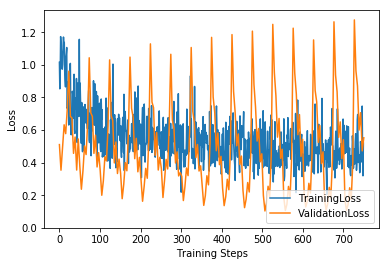

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

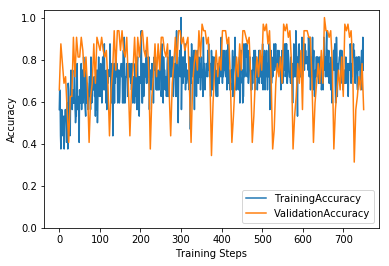

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

In [0]:
ground_truth = validation_generator.classes
filenames = validation_generator.filenames
label_to_index = validation_generator.class_indices
index_to_label = dict((v,k) for k, v in label_to_index.items())
predictions = model.predict_generator(validation_generator, steps=None)

# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [0]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-2] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(SAMPLE_TEST_FOLDER + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

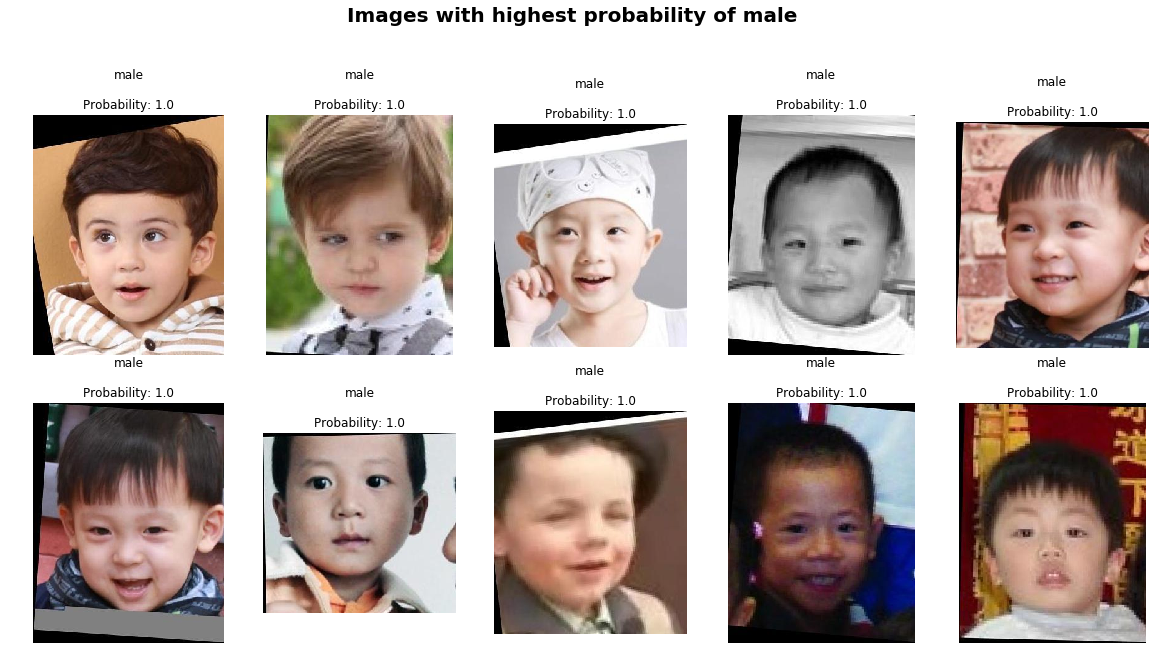

In [0]:
class_index = 1
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, class_index, 10, False)
message = 'Images with highest probability of ' + index_to_label[class_index]
display(most_confident_dog_images, message)

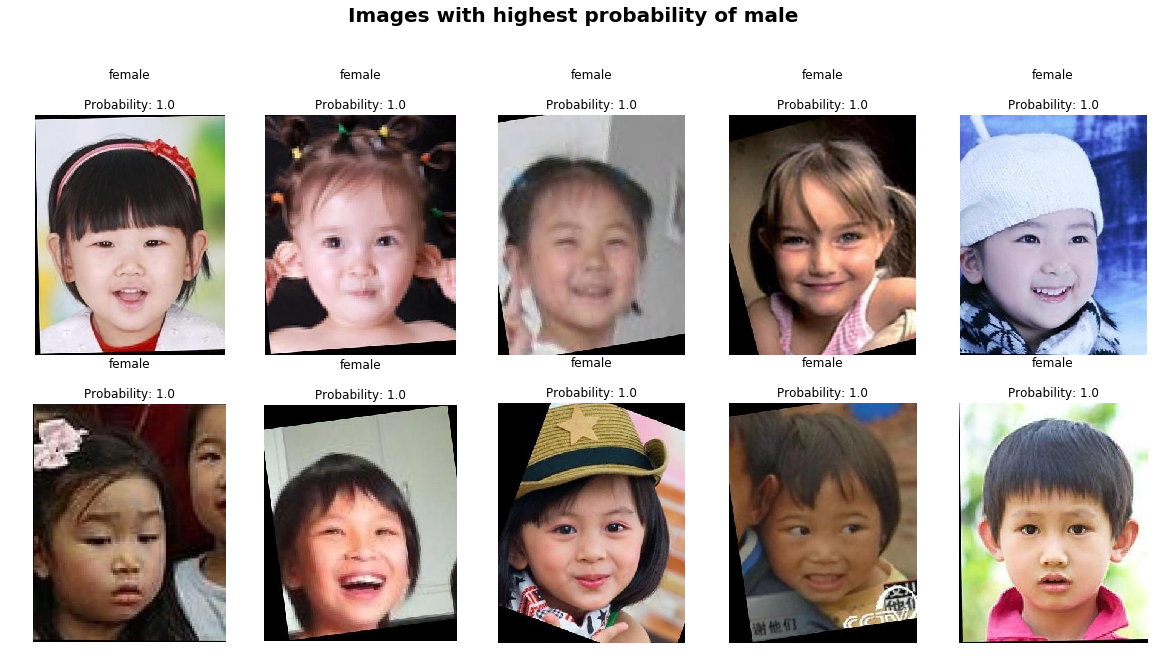

In [0]:
class_index = 1
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, class_index, 10, False)
message = 'Images with highest probability of ' + index_to_label[class_index]
display(most_confident_dog_images, message)

### InceptionV3

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# create the base pre-trained model
inception_v3 = InceptionV3(input_shape=(192, 192, 3) , weights='imagenet', include_top=False)
inception_v3.trainable=False

model = tf.keras.Sequential([
    inception_v3,
    Flatten(),
    Dense(4056, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 4056)              132911064 
_________________________________________________________________
dropout_14 (Dropout)         (None, 4056)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               1038592   
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                

In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
TRAIN_SAMPLES = 10658
VALIDATION_SAMPLES = 2664

model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['acc'])

num_steps_train = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE)

model.fit_generator(train_generator,
          steps_per_epoch = num_steps_train,
          epochs=10,
          validation_data = validation_generator,
          validation_steps = num_steps_val,
          callbacks=callbacks_list)

Epoch 1/10
 83/334 [======>.......................] - ETA: 33s - loss: 0.4779 - acc: 0.8750
Epoch 00001: val_acc did not improve from 0.87500
334/334 [==============================] - 116s 349ms/step - loss: 0.6586 - acc: 0.6875 - val_loss: 0.4781 - val_acc: 0.8750
Epoch 2/10
 83/334 [======>.......................] - ETA: 21s - loss: 0.4543 - acc: 0.9062
Epoch 00002: val_acc did not improve from 0.87500
334/334 [==============================] - 102s 307ms/step - loss: 0.5602 - acc: 0.7500 - val_loss: 0.4554 - val_acc: 0.8750
Epoch 3/10
 83/334 [======>.......................] - ETA: 21s - loss: 0.4352 - acc: 0.9375
Epoch 00003: val_acc did not improve from 0.87500
334/334 [==============================] - 102s 305ms/step - loss: 0.5341 - acc: 0.6875 - val_loss: 0.4343 - val_acc: 0.8750
Epoch 4/10
 83/334 [======>.......................] - ETA: 21s - loss: 0.4248 - acc: 0.9375
Epoch 00004: val_acc did not improve from 0.87500
334/334 [==============================] - 102s 306ms/ste

In [0]:
model.save('gender.h5')

In [0]:
ground_truth = validation_generator.classes
filenames = validation_generator.filenames
label_to_index = validation_generator.class_indices
index_to_label = dict((v,k) for k, v in label_to_index.items())
predictions = model.predict_generator(validation_generator, steps=None)

# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

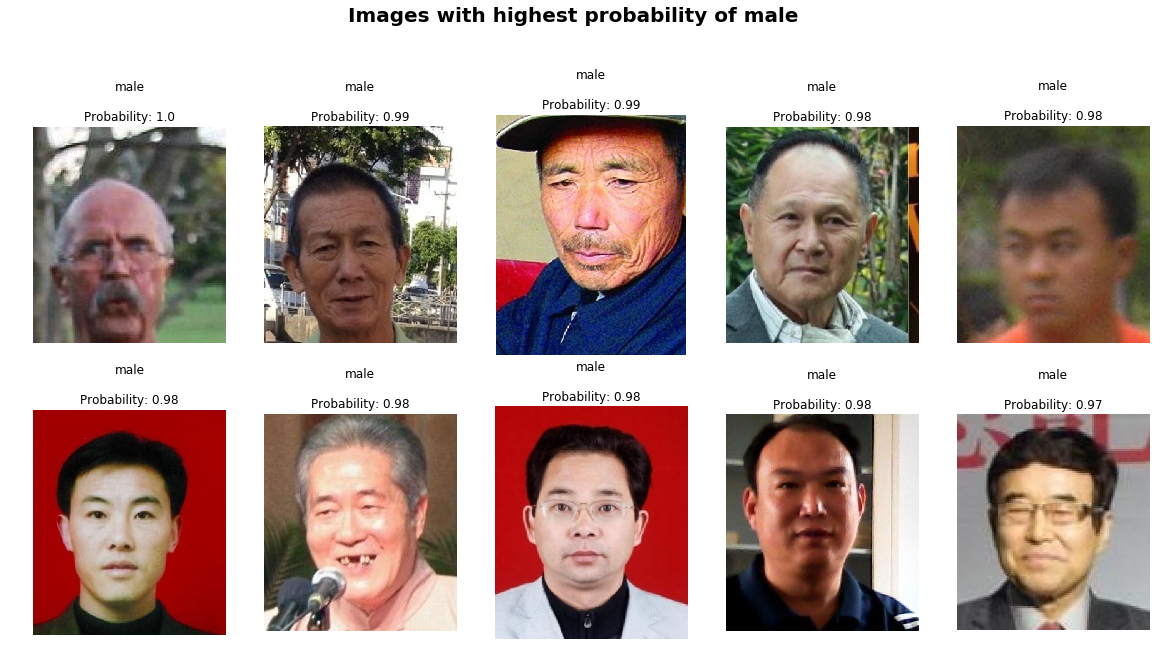

In [0]:
class_index = 1
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, True, class_index, 10, False)
message = 'Images with highest probability of ' + index_to_label[class_index]
display(most_confident_dog_images, message)

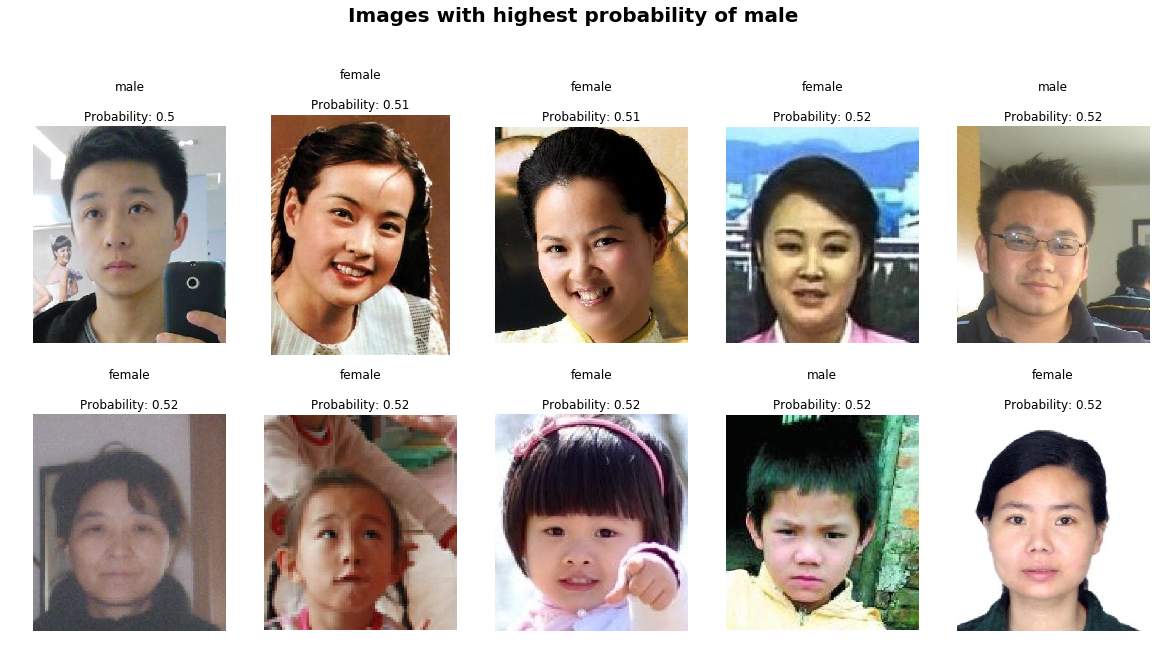

In [0]:
class_index = 1
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, class_index, 10, False)
message = 'Images with highest probability of ' + index_to_label[class_index]
display(most_confident_dog_images, message)

In [0]:
reload_model = tf.keras.models.load_model('inception_samples.h5')

In [0]:
import os 
model_version = "1"
model_name = "gender"
model_path = os.path.join(model_name,model_version)
tf.saved_model.save(model)

In [0]:
model.save('../models/inception_samples_1.h5')

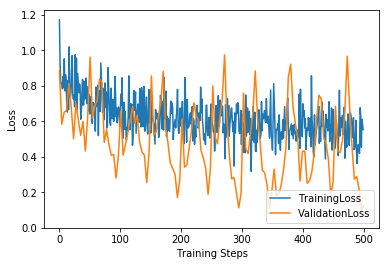

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

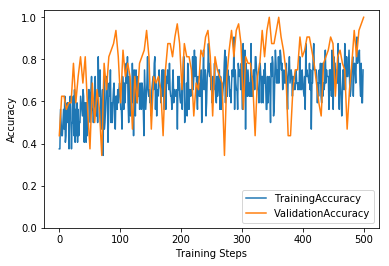

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

In [0]:
model.save_weights('../models/inception_sample_1.h5')

#### Levi_Hassner Model

In [0]:
model = tf.keras.Sequential([
    
    Conv2D(96, kernel_size=(7, 7), strides=(4,4), padding= 'valid', activation='relu', input_shape=(192, 192, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding = 'valid'),
    
    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding = 'valid'),
    
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding = 'valid'),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])

In [0]:
TRAIN_SAMPLES = 1600
VALIDATION_SAMPLES = 400

sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer= sgd,
              metrics=['acc'])

num_steps_train = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE)

model.fit_generator(train_generator,
          steps_per_epoch = num_steps_train,
          epochs=15,
          validation_data = validation_generator,
          validation_steps = num_steps_val,
          callbacks=[batch_stats_callback])

Epoch 1/15
50/50 [==============================] - 20s 400ms/step - loss: 0.6964 - acc: 0.6562 - val_loss: 0.6955 - val_acc: 0.0000e+00
Epoch 2/15
50/50 [==============================] - 18s 355ms/step - loss: 0.6954 - acc: 0.3750 - val_loss: 0.6947 - val_acc: 0.2500
Epoch 3/15
50/50 [==============================] - 18s 350ms/step - loss: 0.6957 - acc: 0.5312 - val_loss: 0.6943 - val_acc: 0.3750
Epoch 4/15
50/50 [==============================] - 16s 330ms/step - loss: 0.6985 - acc: 0.5000 - val_loss: 0.6940 - val_acc: 0.3125
Epoch 5/15
50/50 [==============================] - 16s 328ms/step - loss: 0.6945 - acc: 0.5000 - val_loss: 0.6939 - val_acc: 0.1875
Epoch 6/15
13/50 [======>.......................] - ETA: 10s - loss: 0.6925 - acc: 0.5625

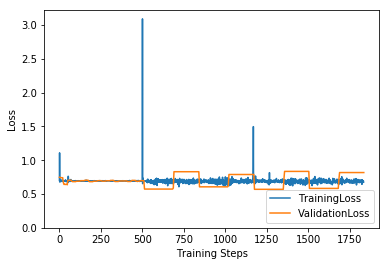

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

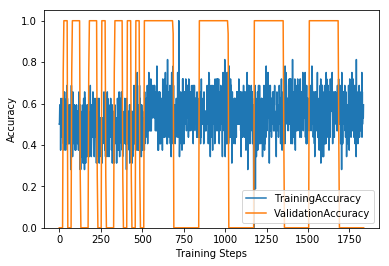

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

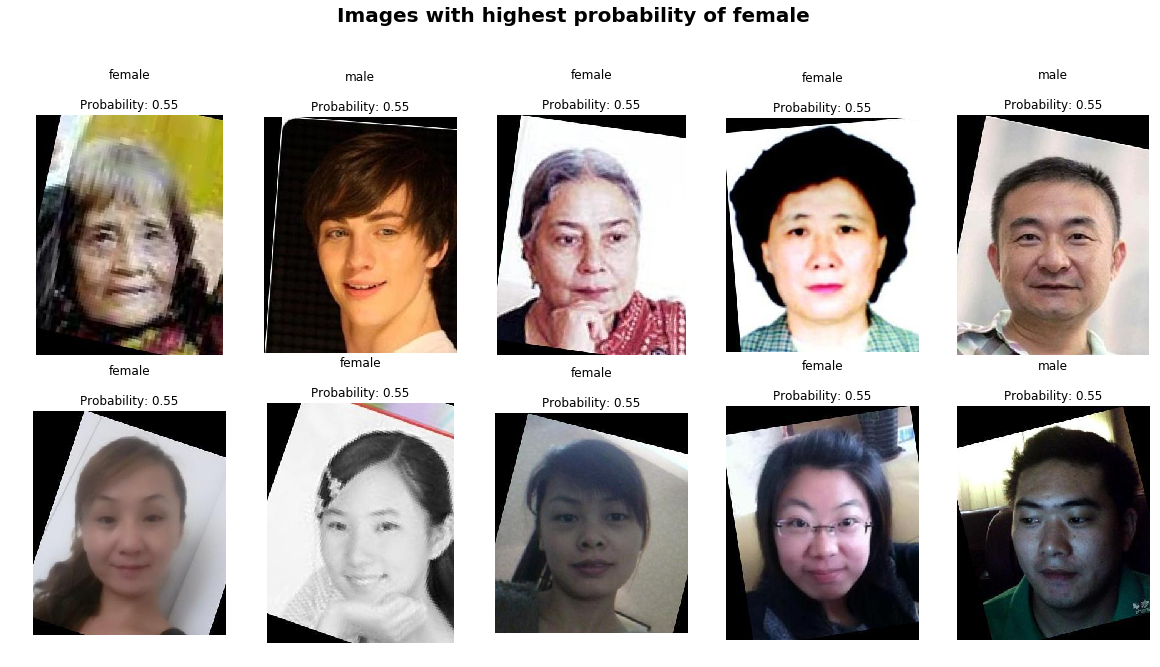

In [0]:
class_index = 0
most_confident_dog_images = get_images_with_sorted_probabilities(prediction_table, False, class_index, 10, False)
message = 'Images with highest probability of ' + index_to_label[class_index]
display(most_confident_dog_images, message)